In [1]:
import warnings
warnings.filterwarnings('ignore')

import ast
import math
import pandas as pd
import glob
import numpy as np
import cv2

from simplification.cutil import simplify_coords

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import os
import datetime as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import re
import ast
import cv2
import csv
import time
import ast
import urllib
from PIL import Image, ImageDraw
from tqdm import tqdm
from dask import bag, threaded
import matplotlib
import matplotlib.pyplot as pltc
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from dask import bag, threaded
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras import applications
import os

Base_Size = 256
data_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Doodle_Data/'
input_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Prediction/'
sub_Directory = 'D:/APM/'
num_csv = 100
num_class = 340
size = 64
steps = 2000
batchsize = 256
epochs = 150

print(os.listdir("C:/Users/wangy/OneDrive/Desktop/Doodle"))

['.ipynb_checkpoints', '1 class per label.csv', 'cnn.csv', 'CNN.h5', 'CNN.ipynb', 'Doodle_Data', 'Doodle_Recognition_new.ipynb', 'gs.png', 'MobileNet.h5', 'MobileNetRGB.ipynb', 'resnet.ipynb', 'resnet50v2.h5', 'sample_submission.csv', 'Screenshot', 'test_simplified.csv', 'vgg16.ipynb']


In [2]:
#Test
def draw_cv2(raw_strokes, size=size, lw=6):
    img = np.zeros((Base_Size, Base_Size))
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            img = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    return (cv2.resize(img, (size, size))/ 255.)

#Data Augmentation
def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(data_Directory, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                x = np.zeros((len(df), size, size))
                df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]   
                df['drawing'] = df['drawing'].apply(draw_cv2)
                x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
                y = tf.keras.utils.to_categorical(df.y, num_classes=num_class)
                yield x, y
                  

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]
    x = np.zeros((len(df), size, size))
    df['drawing'] = df['drawing'].apply(draw_cv2)
    x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
    return x

In [3]:
valid_df = pd.read_csv(os.path.join(data_Directory, 'train_k{}.csv.gz'.format(num_csv - 1)), nrows=30000)
x_valid = df_to_image_array(valid_df, size)
y_valid = tf.keras.utils.to_categorical(valid_df.y, num_classes=num_class)
print(x_valid.shape, y_valid.shape)

(30000, 64, 64, 1) (30000, 340)
Validation array memory 0.92 GB


In [4]:
train_datagen = image_generator(size=size, batchsize=batchsize, ks=range(num_csv - 1))

In [5]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [6]:
base_model = applications.ResNet50V2(weights= None, include_top=False, input_shape= (size,size,1))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(340, activation='softmax')(x)

model = Model(base_model.input, x)

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001),
                      metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.3, patience=5,
                      min_delta=0.005, mode='max', verbose=1),
    ModelCheckpoint('resnet50v2.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True, save_weights_only=True)
]


clf = model.fit(
    train_datagen, steps_per_epoch=steps, epochs=epochs, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/150
2000/2000 [==============================] - 281s 140ms/step - loss: 3.6234 - categorical_crossentropy: 3.6234 - categorical_accuracy: 0.2235 - top_3_accuracy: 0.3917 - val_loss: 2.3344 - val_categorical_crossentropy: 2.3344 - val_categorical_accuracy: 0.4498 - val_top_3_accuracy: 0.6650
Epoch 2/150
2000/2000 [==============================] - 269s 135ms/step - loss: 2.4936 - categorical_crossentropy: 2.4936 - categorical_accuracy: 0.4293 - top_3_accuracy: 0.6382 - val_loss: 2.4960 - val_categorical_crossentropy: 2.4960 - val_categorical_accuracy: 0.4223 - val_top_3_accuracy: 0.6271
Epoch 3/150
2000/2000 [==============================] - 272s 136ms/step - loss: 2.0717 - categorical_crossentropy: 2.0717 - categorical_accuracy: 0.5258 - top_3_accuracy: 0.7218 - val_loss: 1.6089 - val_categorical_crossentropy: 1.6089 - val_categorical_accuracy: 0.6105 - val_top_3_accuracy: 0.7945
Epoch 4/150
2000/2000 [==============================] - 271s 135ms/step - loss: 1.7754 - categor

2000/2000 [==============================] - ETA: 0s - loss: 0.7918 - categorical_crossentropy: 0.7918 - categorical_accuracy: 0.7991 - top_3_accuracy: 0.9196
Epoch 00051: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
2000/2000 [==============================] - 269s 134ms/step - loss: 0.7918 - categorical_crossentropy: 0.7918 - categorical_accuracy: 0.7991 - top_3_accuracy: 0.9196 - val_loss: 0.8397 - val_categorical_crossentropy: 0.8397 - val_categorical_accuracy: 0.7870 - val_top_3_accuracy: 0.9131
Epoch 52/150
2000/2000 [==============================] - 270s 135ms/step - loss: 0.8141 - categorical_crossentropy: 0.8141 - categorical_accuracy: 0.7946 - top_3_accuracy: 0.9166 - val_loss: 0.8396 - val_categorical_crossentropy: 0.8396 - val_categorical_accuracy: 0.7864 - val_top_3_accuracy: 0.9133
Epoch 53/150
2000/2000 [==============================] - 270s 135ms/step - loss: 0.8399 - categorical_crossentropy: 0.8399 - categorical_accuracy: 0.7899 - top_3_accurac

2000/2000 [==============================] - 271s 135ms/step - loss: 0.8031 - categorical_crossentropy: 0.8031 - categorical_accuracy: 0.7969 - top_3_accuracy: 0.9185 - val_loss: 0.8393 - val_categorical_crossentropy: 0.8393 - val_categorical_accuracy: 0.7870 - val_top_3_accuracy: 0.9135
Epoch 98/150
2000/2000 [==============================] - 268s 134ms/step - loss: 0.8361 - categorical_crossentropy: 0.8361 - categorical_accuracy: 0.7903 - top_3_accuracy: 0.9142 - val_loss: 0.8390 - val_categorical_crossentropy: 0.8390 - val_categorical_accuracy: 0.7870 - val_top_3_accuracy: 0.9134
Epoch 99/150
2000/2000 [==============================] - 272s 136ms/step - loss: 0.7956 - categorical_crossentropy: 0.7956 - categorical_accuracy: 0.7993 - top_3_accuracy: 0.9196 - val_loss: 0.8393 - val_categorical_crossentropy: 0.8393 - val_categorical_accuracy: 0.7869 - val_top_3_accuracy: 0.9134
Epoch 100/150
2000/2000 [==============================] - 274s 137ms/step - loss: 0.8105 - categorical_cro

2000/2000 [==============================] - 273s 136ms/step - loss: 0.7816 - categorical_crossentropy: 0.7816 - categorical_accuracy: 0.8019 - top_3_accuracy: 0.9208 - val_loss: 0.8392 - val_categorical_crossentropy: 0.8392 - val_categorical_accuracy: 0.7871 - val_top_3_accuracy: 0.9133
Epoch 144/150
2000/2000 [==============================] - 270s 135ms/step - loss: 0.8180 - categorical_crossentropy: 0.8180 - categorical_accuracy: 0.7943 - top_3_accuracy: 0.9168 - val_loss: 0.8394 - val_categorical_crossentropy: 0.8394 - val_categorical_accuracy: 0.7868 - val_top_3_accuracy: 0.9132
Epoch 145/150
2000/2000 [==============================] - 273s 136ms/step - loss: 0.8178 - categorical_crossentropy: 0.8178 - categorical_accuracy: 0.7937 - top_3_accuracy: 0.9163 - val_loss: 0.8393 - val_categorical_crossentropy: 0.8393 - val_categorical_accuracy: 0.7871 - val_top_3_accuracy: 0.9133
Epoch 146/150
2000/2000 [==============================] - ETA: 0s - loss: 0.8095 - categorical_crossentr

In [9]:
def plot_graph(model, title):
    plt.plot(model.history['categorical_accuracy'])
    plt.plot(model.history['val_categorical_accuracy'])
    plt.plot(model.history['top_3_accuracy'])
    plt.plot(model.history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test Top 3', 'Validation Top 3'], loc='lower right')
    plt.show()
    plt.plot(model.history['categorical_crossentropy'])
    plt.plot(model.history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

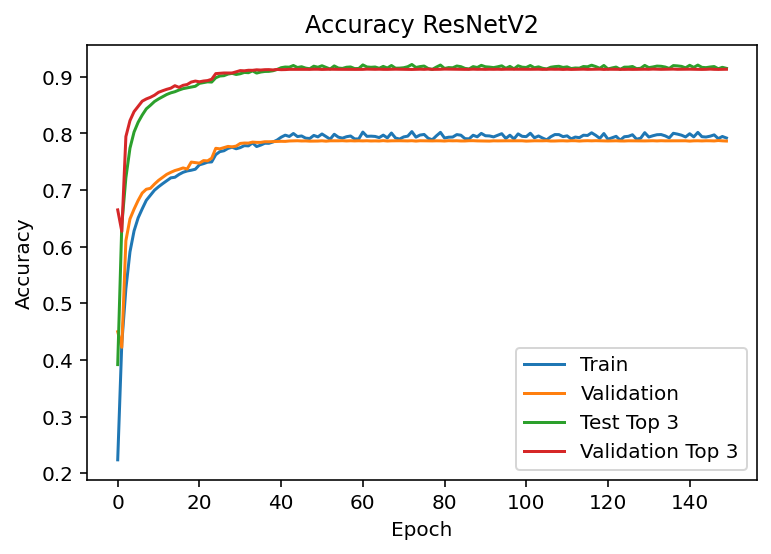

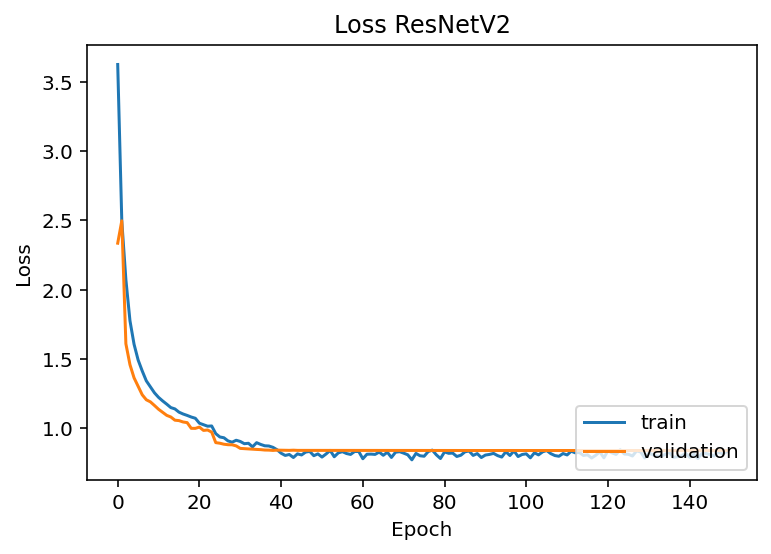

In [10]:
plot_graph(clf, "ResNetV2")

# Turn in for Kaggle

In [2]:
#the following code is excerpt from Kaggle and changed

In [11]:
pred_results = []
chunksize = 10000
reader = pd.read_csv(input_Directory + 'test_simplified.csv', chunksize=chunksize)
for chunk in tqdm(reader):
    imgs = df_to_image_array(chunk)
    pred = model.predict(imgs, verbose=1)
    top_3 =  np.argsort(-pred)[:, 0:3]  
    pred_results.append(top_3)
print("Finished test predictions...")

#prepare data for saving
classes_path = os.listdir(sub_Directory + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(classes_path)}

reverse_dict = {v: k for k, v in class_dict.items()}
pred_results = np.concatenate(pred_results)
print("Finished data prep...")

preds_df = pd.DataFrame({'first': pred_results[:,0], 'second': pred_results[:,1], 'third': pred_results[:,2]})
preds_df = preds_df.replace(reverse_dict)

0it [00:00, ?it/s]

313/313 [==============================] - 3s 9ms/step


1it [00:09,  9.02s/it]

313/313 [==============================] - 3s 9ms/step


2it [00:17,  8.81s/it]

313/313 [==============================] - 3s 9ms/step


3it [00:25,  8.62s/it]

313/313 [==============================] - 3s 9ms/step


4it [00:33,  8.50s/it]

313/313 [==============================] - 3s 9ms/step


5it [00:41,  8.43s/it]

313/313 [==============================] - 3s 9ms/step


6it [00:50,  8.38s/it]

313/313 [==============================] - 3s 9ms/step


7it [00:58,  8.31s/it]

313/313 [==============================] - 3s 9ms/step


8it [01:06,  8.31s/it]

313/313 [==============================] - 3s 9ms/step


9it [01:14,  8.26s/it]

313/313 [==============================] - 3s 9ms/step


10it [01:22,  8.22s/it]

313/313 [==============================] - 3s 9ms/step


11it [01:31,  8.20s/it]

69/69 [==============================] - 1s 13ms/step


12it [01:33,  7.78s/it]

Finished test predictions...
Finished data prep...


In [12]:
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv(input_Directory + 'sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('resnet.csv')
sub.head()

,word
key_id,
9000003627287624,radio stereo binoculars
9000010688666847,hockey_puck pool bottlecap
9000023642890129,The_Great_Wall_of_China castle fence
9000038588854897,mountain tent The_Eiffel_Tower
9000052667981386,fireplace campfire fire_hydrant
